In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import (
    Input, 
    LSTM, 
    Embedding, 
    Dense, 
    Bidirectional,
    Softmax
)

### Coding the encoder

In [77]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, T, V, D, M, **kwargs):
        super().__init__(**kwargs)
        self.embedding = Embedding(V, D, input_length = T)
        self.lstm = Bidirectional(LSTM(M, return_sequences = True))

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        return x

def test_encoder(T = 10, V = 2000, D = 200, M = 15, N = 128):
    data = np.random.random((N, T))
    encoder = Encoder(T, V, D, M)
    assert encoder(data).shape == (N, T, 2 * M)
    print("Encoder passed test")

test_encoder()

Encoder passed test


### Softmax over the second dimension(Not the last one)

In [3]:
# T = 10
# V = 2000
# D = 200
# M = 15
# N = 128

In [78]:
softmax = Softmax(axis = 1) # softmax over time

def test_softmaxovertime():
    data = np.random.random((128,20,1))
    val = softmax(data)[np.random.randint(0,20)].numpy().sum()
    assert abs(val -1) <= 1e-4
    print('Passed softmax test')
    
test_softmaxovertime()

Passed softmax test


### Build the decoder header

In [80]:
class DecoderHeader(tf.keras.layers.Layer):
    def __init__(self, V, D, **kwargs):
        super().__init__(**kwargs)
        T = 1
        self.embedding = Embedding(V, D, input_length = T)

    def call(self, inputs):
        x = self.embedding(inputs)
        return x

def test_decoder_header(V = 2000, D = 200, N = 128):
    decoder_header = DecoderHeader(V, D)
    decoder_input_data = np.random.randint(0,100, (N, 1))
    assert decoder_header(decoder_input_data).shape == (N, 1, D)
    print("Decoder header(embedding) test success.")

test_decoder_header()


Decoder header(embedding) test success.


### Build the decoder LSTM

In [81]:
class DecoderLSTM(tf.keras.layers.Layer):
    def __init__(self, M, **kwargs):
        super().__init__(**kwargs)
        self.M = M
        self.lstm = LSTM(M, return_state = True)

    def call(self, inputs, state = None):
        if not state:
            s = tf.zeros((len(inputs),self.M))
            state = [s, s]
        return self.lstm(inputs, initial_state = state)

def test_decoder(N = 128, D = 200, M = 15):
    decoder_lstm = DecoderLSTM(M)

    o, h, c = decoder_lstm(
        np.random.random((N, 1, D)), 
        state = [tf.zeros((N,M)),
        tf.zeros((N,M))]
        )

    assert  all((o == h).numpy().flatten())
    assert o.shape == h.shape == c.shape ==  (N,M)
    print("Decoder lstm test successfully")
test_decoder()

Decoder lstm test successfully


### Put the 2 decoder components inside 1 decoder

In [82]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, V, D, M, T = 1, **kwargs):
        super().__init__(**kwargs)
        self.M = M
        self.embedding = Embedding(V, D, input_length = T)
        self.lstm = LSTM(M, return_state = True)
        self.dense = Dense(V, activation = 'softmax')

    def call(self, inputs, state = None):
        if not state:
            s = tf.zeros((len(inputs),self.M))
            state = [s, s]
        
        x = self.embedding(inputs)
        o, h, c = self.lstm(x, initial_state = state)
        output = self.dense(o)
        return output, [h,c]

In [83]:
def test_decoder(V = 2000, M = 15,D = 200,N = 128,T = 1):
    s = tf.zeros((N, M))
    states = [[s,s],None]
    for state in states:
    
        decoder = Decoder(V, D, M ,T)
        out, state = decoder(np.random.randint(1,V, (N,T)), state = None)
        assert out.shape == (N, V)
        assert state[0].shape == (N, M)
        assert state[1].shape == (N, M)
    print('Passed decoder test')

test_decoder()



Passed decoder test


### The context vector is ignored here, so I need rebuild the layer

In [84]:
from tensorflow.keras.layers import Concatenate

In [85]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, V, D, M, T = 1, **kwargs):
        super().__init__(**kwargs)
        self.M = M
        self.embedding = Embedding(V, D, input_length = T)
        self.lstm = LSTM(M, return_state = True)
        self.dense = Dense(V, activation = 'softmax')
        self.concat = Concatenate(axis = -1)

    def call(self, inputs, state = None):
        
        if not state:
            s = tf.zeros((len(inputs[0]),self.M))
            state = [s, s]

        # input contains 2 things
        # 1 - decoder sequence input
        # 2 - context vectors input
        # these 2 things a detached here
        decoder_inputs, context = inputs
        
        # embedding decoder sequence inputs
        x = self.embedding(decoder_inputs)

        # concat context and embedded vectors
        x = self.concat([x, context])

        # go through decoder lstm
        o, h, c = self.lstm(x, initial_state = state)

        # go through decoder dense
        output = self.dense(o)

        # return decoder final output and lstm states
        return output, [h,c]

In [86]:
def decoder_full_test(N = 128,V = 2000,D = 200,M = 15,T = 1):

    decoder = Decoder(V, D, M ,T)
    decoder_in_data = np.random.randint(1,V, (N,T))
    context = np.random.random((N, T, M))
    decoder_inputs = [decoder_in_data, context]
    out, state = decoder(decoder_inputs, state = None)
    assert out.shape == (N, V)
    assert state[0].shape == (N, M) == state[1].shape
    print("Passes all decoder test")
decoder_full_test()

Passes all decoder test


In [87]:
from tensorflow.keras.layers import RepeatVector, Concatenate, Dot

In [88]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, T, M, **kwargs):
        super().__init__(**kwargs)
        self.M = M
        self.repeator = RepeatVector(T)
        self.concater = Concatenate()
        self.densor1 = Dense(M)
        self.densor2 = Dense(1)
        self.dotter = Dot(axes = 1)
        self.softmax = Softmax(axis = 1)
        
    def call(self, encoder_output, prev_decoder_state):
        s_repeated = self.repeator(prev_decoder_state)
        concat_vector = self.concater([encoder_output, s_repeated])
        weights = self.densor1(concat_vector)
        weights = self.densor2(weights)
        weights = self.softmax(weights)
        context = self.dotter([weights, encoder_output])
        return context
    
def test_attention(T = 100, M = 15, N = 128):

    prev_state = tf.zeros((N, M))
    encoder_out_tensor = tf.random.normal((N, T, 2*M))
    context = AttentionLayer(T, M)(encoder_out_tensor,prev_state)
    assert context.shape == (N, 1, 2*M)
    print("Attention test success")
    
test_attention()

Attention test success


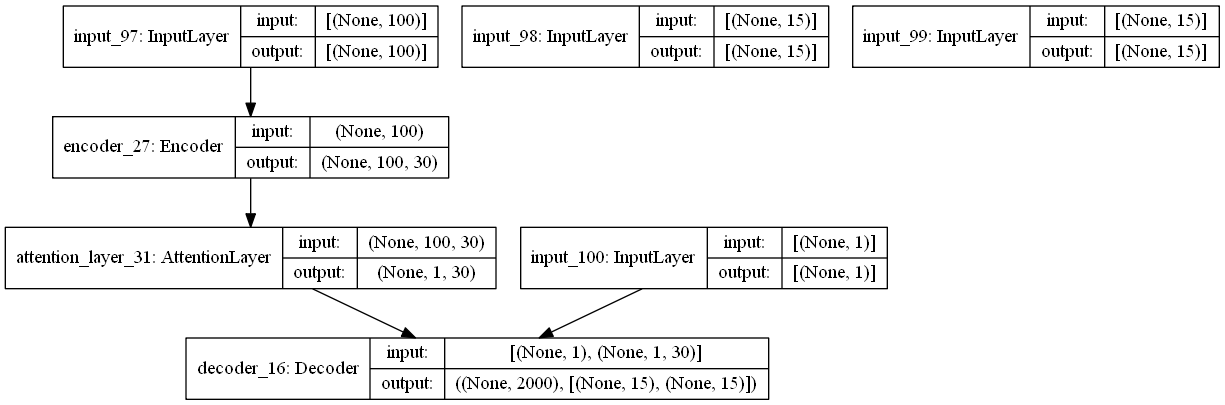

In [117]:
N = 128
T = 100
D = 200
V = 2000
M = 15
encoder_input_tensor = Input((T,))
s0 = Input((M,))
c0 = Input((M,))

# 这儿有一次
encoder = Encoder(T,V,D,M)
encoder_output_tensor = encoder(encoder_input_tensor)

#这儿要再循环里
attention = AttentionLayer(T, M)
context = attention(encoder_output_tensor, s0)
decoder_input = Input((1,))
decoder = Decoder(V, D, M)
out, states = decoder([decoder_input, context],[s0, c0])
model = tf.keras.models.Model([encoder_input_tensor,decoder_input, s0, c0],[out, states])
tf.keras.utils.plot_model(model, show_shapes = True)


In [111]:
out.shape

TensorShape([None, 2000])